In [1]:
from valhalla import Actor, get_config
from valhalla.utils import decode_polyline

import geopandas as gpd
from shapely.geometry import LineString, Polygon, Point
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import contextily as cx

BASEMAP_SOURCE = cx.providers.CartoDB.VoyagerNoLabels

# Valhalla for Python

In order to use Valhalla's Python bindings, we need to have access to a Valhalla graph. For these examples, we will be using a graph for the Dutch province of Utrecht. You can use our user-friendly Docker image to create a graph .tar:

```
docker run -it --name valhalla_gis-ops -p 8002:8002 -v $PWD/custom_files:/custom_files -e tile_urls=http://download.geofabrik.de/europe/netherlands/utrecht-latest.osm.pbf gisops/valhalla:latest
```

Once you have created a graph locally, you can use it like this:

In [2]:
config = get_config(tile_extract='./custom_files/valhalla_tiles.tar', verbose=True)
# instantiate Actor to load graph and call actions
actor = Actor(config)

## Locate
Let's start with the basics: the `locate` endpoint lets you gather information about streets and intersections close to an input point. So if we run locate on Utrecht's central plaza, we get information about the roads that run closeby (set `verbose` to `False` to only get way_ids and some other basic info):

In [3]:
location = actor.locate({"verbose": True, "locations":[{"lat":52.0909045,"lon":5.1224405}]})
location[0]["edges"][0]

{'predicted_speeds': [],
 'linear_reference': 'KwOkVCUK3XLFAQBfABoyVug=',
 'edge_info': {'way_id': 7010307,
  'shape': 'abkjbB}xqwHuGa_@mEiY',
  'mean_elevation': 1234,
  'speed_limit': 30,
  'bike_network': {'mountain': False,
   'local': False,
   'regional': True,
   'national': True},
  'names': ['Domplein']},
 'edge_id': {'id': 31981,
  'value': 1073110839074,
  'tile_id': 818660,
  'level': 2},
 'edge': {'sidewalk_left': False,
  'sidewalk_right': False,
  'lane_count': 1,
  'stop_sign': False,
  'sac_scale': 'none',
  'yield_sign': False,
  'not_thru': False,
  'forward': True,
  'bike_network': True,
  'round_about': False,
  'access': {'motorcycle': True,
   'moped': True,
   'wheelchair': True,
   'taxi': True,
   'HOV': True,
   'truck': True,
   'emergency': False,
   'pedestrian': True,
   'car': True,
   'bus': True,
   'bicycle': True},
  'bridge': False,
  'tunnel': False,
  'destination_only': False,
  'seasonal': False,
  'classification': {'link': False,
   'internal

## Directions

We can use the directions endpoint to find the least cost path between 2 or more points. In this example, we want to know the travel distance by car from a set of addresses to the city center.

In [4]:
points = gpd.read_file("./addresses.geojson") # some random address points in Utrecht
to_geom = Point(5.1224405,52.0909045) # the city center (i.e. the domplein)

In [5]:
data = []
geoms = []
for ix, point in points.iterrows():
    from_coords = point.geometry.coords[0]
    query = {"locations": [{"lat": y, "lon": x} for x,y in (from_coords, to_geom.coords[0])], "costing": "auto"}
    try:
        route = actor.route(query)
        geom = decode_polyline(route["trip"]["legs"][0]["shape"])
        duration = route["trip"]["legs"][0]["summary"]["time"]
        distance = route["trip"]["legs"][0]["summary"]["length"]
        data.append({"duration": duration / 60, "distance": distance, "index": ix})
        geoms.append(LineString(geom))
    except RuntimeError:
        pass

In [6]:
routes = gpd.GeoDataFrame(data=data, geometry=geoms, crs="EPSG:4326").set_index("index")

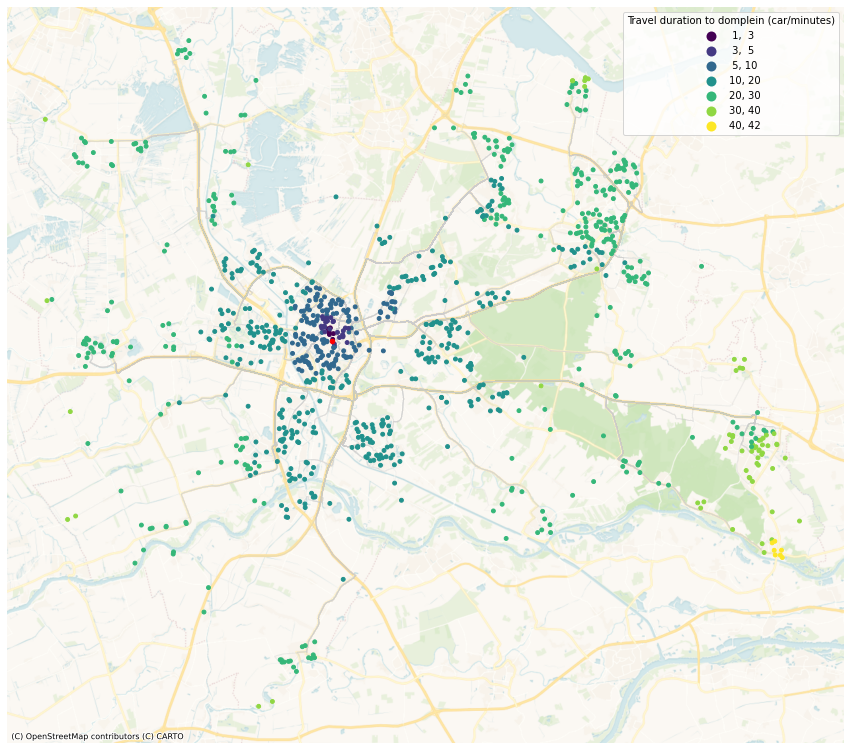

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
routes.to_crs("EPSG:3857").plot(ax=ax, color="#ccc", alpha=0.1, linewidth=1)
points.join(routes, rsuffix="line_").to_crs("EPSG:3857").plot(ax=ax, column="duration", scheme='user_defined', classification_kwds={'bins':[3, 5, 10, 20, 30, 40]}, markersize=15, zorder=10, legend=True, legend_kwds={"title": "Travel duration to domplein (car/minutes)", "fmt": "{:.0f}"})
gpd.GeoDataFrame(geometry=[to_geom], crs="EPSG:4326").to_crs("EPSG:3857").plot(ax=ax, color="red", markersize=20, zorder=20)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=BASEMAP_SOURCE)
_ = ax.axis("off")

## Isochrones

We can also call the isochrone endpoint. In this example, we want to know how far one can cycle within 5, 10 and 15 minutes from a given set of locations. Instead of a `time` key, we can also provide `distance` in kilometers.

In [8]:
PLOT_KWDS = [
    {"facecolor": "#0070FF66", "edgecolor": "#0070FF"},
    {"facecolor": "#FFF88066", "edgecolor": "#FFF880"},
    {"facecolor": "#E6002666", "edgecolor": "#E60026"},
]

In [9]:
data = []
geoms = []
for ix, point in points.iloc[[766, 25, 61, 552, 732, 897]].iterrows():
    coords = point.geometry.coords[0]
    query = {"locations": [{"lat": coords[1], "lon": coords[0]}], "costing": "bicycle", "contours":[{"time":5},{"time":10}, {"time": 15}]}
    try:
        isochrones = actor.isochrone(query)
        for contour_ix, isochrone in enumerate(isochrones["features"]):
            geom = isochrone["geometry"]["coordinates"]
            geoms.append(Polygon(geom))
            time = isochrone["properties"]["contour"]
            data.append({"time": time, "location_ix": ix, "contour_ix": contour_ix})
    except RuntimeError as e: 
        print(e)

In [10]:
isochrones_df = gpd.GeoDataFrame(data=data, geometry=geoms, crs="EPSG:4326")

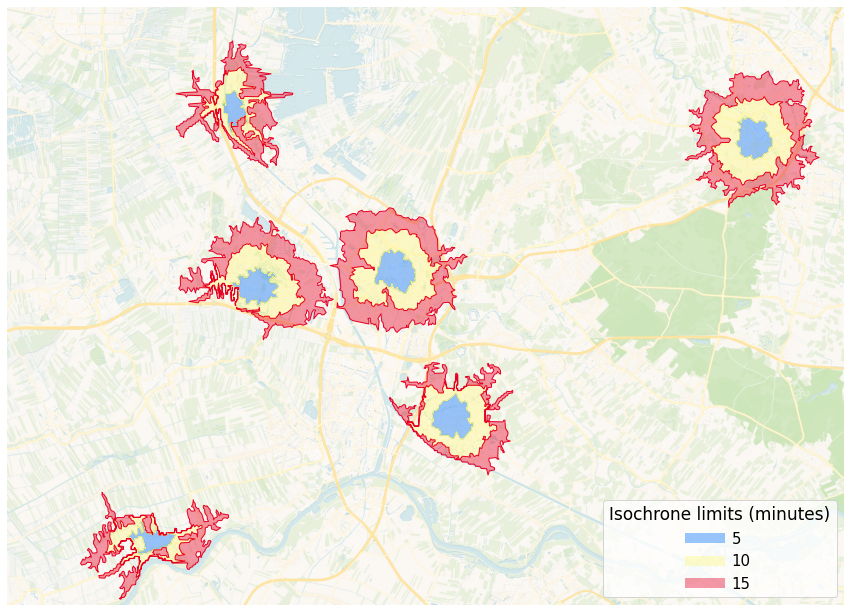

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
IMG, EXT = cx.bounds2img(*isochrones_df.geometry.total_bounds, ll=True, source=BASEMAP_SOURCE)
_ = ax.imshow(IMG, extent=EXT)
for n, group in reversed(list(isochrones_df.groupby("contour_ix"))):
    plot_kwds = list(reversed(PLOT_KWDS))[n]
    
    # some geometric set operations to get the 'doughnut' geometries of the outer contours
    if n == 2:
        group.to_crs("EPSG:3857").plot(ax=ax, **plot_kwds)
    elif n == 1:
        geom = isochrones_df.query("contour_ix == 1").unary_union.difference(isochrones_df.query("contour_ix == 2").unary_union)
        gpd.GeoDataFrame(geometry=[geom], crs="EPSG:4326").to_crs("EPSG:3857").plot(ax=ax, **plot_kwds)
    else:
        geom = isochrones_df.query("contour_ix == 0").unary_union.difference(isochrones_df.query("contour_ix == 1").unary_union)
        gpd.GeoDataFrame(geometry=[geom], crs="EPSG:4326").to_crs("EPSG:3857").plot(ax=ax, **plot_kwds)
    
    _ = ax.axis("off")
    custom_lines = [Line2D([0], [0], color=c["facecolor"], lw=10) for c in PLOT_KWDS]
    legend = ax.legend(custom_lines, ["5", "10", "15"], loc=4, prop={'size': 15}, title="Isochrone limits (minutes)")
    plt.setp(legend.get_title(),fontsize=17)

## Expansion

Now isochrones are a great thing if you want to e.g. find all addresses within x minutes cycling from a given amenity. But what if you're interested in the streets themselves? This is where the `expansion` endpoint comes in: it returns the searched edges for a given action (this can either be `route` or `isochrone`) with the desired `expansion_properties`(in this case, we'll use `duration`). The returned list of edges includes more than the edges actually reachable within the defined times, but we can simply filter them thanks to the specified expansion property.

In [12]:
data = []
geoms = []
for ix, point in points.iloc[[766, 25, 61, 552, 732, 897]].iterrows():
    coords = point.geometry.coords[0]
    query = {"locations": [{"lat": coords[1], "lon": coords[0]}], "costing": "bicycle", "contours":[{"time":5},{"time":10}, {"time": 15}], "action": "isochrone", "expansion_properties": ["durations"]}
    try:
        expansions = actor.expansion(query)
        for idx, line in enumerate(expansions["features"][0]["geometry"]["coordinates"]):
            data.append({"durations": expansions["features"][0]["properties"]["durations"][idx]})
            geoms.append(LineString(line))
    except RuntimeError as e: 
        print(e)

In [13]:
expansion_df = gpd.GeoDataFrame(data=data, geometry=geoms, crs="EPSG:4326")

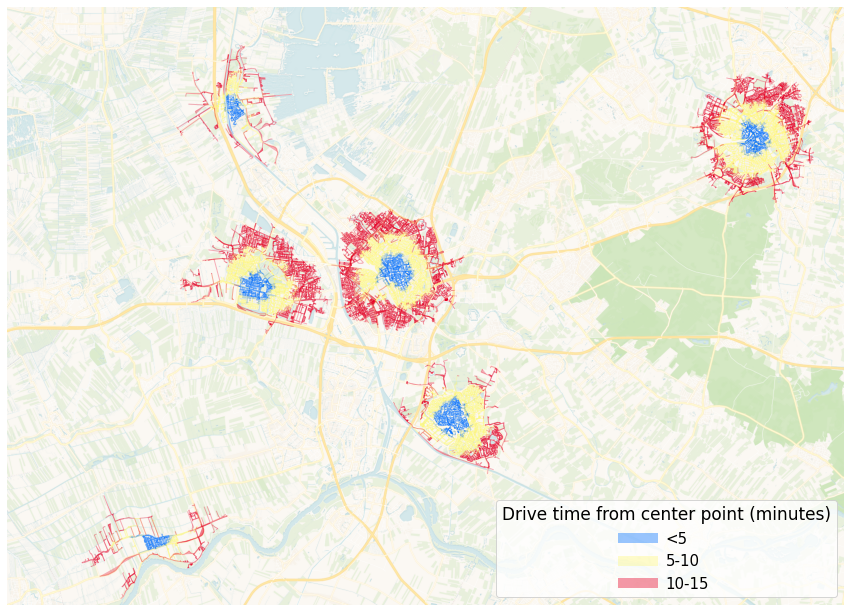

In [14]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
IMG, EXT = cx.bounds2img(*expansion_df.query(f"durations <= {15 * 60}").geometry.total_bounds, ll=True, source=BASEMAP_SOURCE)
durations = (5, 10, 15)
for ix, duration in enumerate(durations):
    _ = ax.imshow(IMG, extent=EXT)
    plot_kwds = PLOT_KWDS[ix]
    
    # filter for duration
    lower_bound = durations[ix-1] if ix != 0 else 0
    expansion_df.query(f"{lower_bound * 60} <= durations <= {duration * 60}").to_crs("EPSG:3857").plot(ax=ax, linewidth=1, alpha=0.3, **plot_kwds)

custom_lines = [Line2D([0], [0], color=c["facecolor"], lw=10) for c in PLOT_KWDS]
legend = ax.legend(custom_lines, ["<5", "5-10", "10-15"], loc=4, prop={'size': 15}, title="Drive time from center point (minutes)")
_ = plt.setp(legend.get_title(),fontsize=17)
_ = ax.axis("off")